# **Рекомендательная система для профпатологов. INSPECTRUM CLINIC.**

# Подгружаем библиотеки, инструменты для работы, а также базу заказчика и дополнительную таблицу из приказа N29

Работа проводится в googlecolab\jupiter-nootbook

Обратите внимание на серьезную разбалансировку данных. Предсавителей класса - **"Годен"** больше всего в таблице, что вызывает затруднения в обучении НС (ей станет проще ставить везде "годен", чтобы получить высокую точность), при этом класса **"НЕ ГОДЕН"**, как такового не существует, вместо него **"ВременноНегоден"**. Также есть такие классы, как **"НуждаетсяВДообследованииИЛечении"**, **"ОграниченноГоден"**, **"ГоденСКоррекциейЗрения"** и др., что говорит об условности этих самых классов. Приказ РФ от 28 января 2021 г. N 29н содержит такую фразу "**перечня медицинских противопоказаний** к осуществлению работ с вредными и (или) опасными производственными факторами", а также не содержит таких слов как годен или негоден. Основной целью данной программы, как следует из названия "Рекомендательная система для профпатологов", является создание рекомендаций для профпатологов, а как известно все в медицине носит рекомендательный характер. Давайте попробуем создать именно рекомендательную систему не ограничиваясь классами, дающую свое предсказание на основе имеющихся факторов подразделяя для начала пациентов без особенностей и группу требующую внимания врача.

In [ ]:
%matplotlib inline

import pandas as pd #табличные данные
import matplotlib.pyplot as plt #графики
from tensorflow.keras import utils #утилиты
from tensorflow.keras.models import Sequential, Model #модель
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, concatenate #слои
from tensorflow.keras.optimizers import Adam, Adadelta #оптимизаторы
from tensorflow.keras.metrics import Precision #метрики
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split #разделитель данных
from keras.layers import Embedding, Flatten
from keras.utils import to_categorical
import seaborn as sns
import numpy as np #нампи
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json #токенизатор

from sklearn.preprocessing import StandardScaler, LabelEncoder #может пригодиться

import time
import re

In [ ]:
from google.colab import drive #подключаю диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/data2.xlsx') #читаем предоставленную таблицу заказчика

In [ ]:
df.head(3)

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология3_Аудиометрия1_ЗначениеПредставление,Оториноларингология1_ЖалобыДополнение_Значение,Оториноларингология1_ЖалобыДополнение_ЗначениеПредставление,Стоматология2_ВП2_Значение,Стоматология2_ВП2_ЗначениеПредставление,Терапия2_ЗаключениеФОГК_Значение,Терапия2_ЗаключениеФОГК_ЗначениеПредставление,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление
0,7f41ca7e-7dac-11ec-80fc-0cc47aab8067,c91e3407-b81f-11e9-80cf-0cc47aab8067,1976-10-24,Женский,Женский,2022-01-25,Периодический,Периодический,False,23c173a7-30d9-11e7-80d8-708bcd7f83cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2ee1f9ac-83dd-11ec-80fc-0cc47aab8067,1a1a5fea-8b7f-11eb-80e8-0cc47aab8067,1987-11-18,Мужской,Мужской,2022-02-02,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9cbb191e-8e24-11ec-80fe-0cc47aab8067,7fe324e0-fa51-11eb-80f6-0cc47aab8067,1985-09-08,Мужской,Мужской,2022-02-15,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_list = df.columns.tolist() #список столбцов
print(column_list)

['ДокументПрохождениеМедосмотра', 'Клиент', 'КлиентДатаРождения', 'КлиентПол', 'КлиентПолПредставление', 'ДатаЗавершенияМедосмотра', 'ТипМедосмотра', 'ТипМедосмотраПредставление', 'ПсихОсвидетельствование', 'Контрагент', 'Цех', 'Профессия', 'ЗаключениеМК', 'ЗаключениеМКПредставление', 'Заключение', 'ДиспансернаяГруппа', 'ДиспансернаяГруппаПредставление', 'ВредныеФакторы', 'ЛабораторныеИсследования1_ДокументПрием', 'ЛабораторныеИсследования1_ДатаПриема', 'ЛабораторныеИсследования1_Салон', 'ЛабораторныеИсследования1_СалонПредставление', 'ЛабораторныеИсследования1_Специализация', 'ЛабораторныеИсследования1_СпециализацияПредставление', 'ЛабораторныеИсследования1_ХР_Рекомендация1', 'ЛабораторныеИсследования1_ХР_Рекомендация1Представление', 'ЛабораторныеИсследования1_ХР_Рекомендация2', 'ЛабораторныеИсследования1_ХР_Рекомендация2Представление', 'ЛабораторныеИсследования1_ХР_РекомендацияСтр', 'ЛабораторныеИсследования1_ОАК_Значение', 'ЛабораторныеИсследования1_ОАК_ЗначениеПредставление', 'Лабо

In [ ]:
# Получение уникальных значений и их количества по ключебому столбцу
unique_values = df['ЗаключениеМК'].unique()
count_values = df['ЗаключениеМК'].value_counts()

# Вывод уникальных значений и их количества
print("Уникальные значения:")
print(unique_values)
print("Количество каждого значения:")
print(count_values)

Уникальные значения:
['Годен' 'ГоденСКоррекциейЗрения' 'ГоденБезРаботНаВысотах'
 'НуждаетсяВДообследованииИЛечении' 'ВременноНегоден' 'ОграниченноГоден'
 nan 'машинист бульдозера' 'Газоспасатель' ' Газоспасатель']
Количество каждого значения:
Годен                               1434
ГоденСКоррекциейЗрения               123
ВременноНегоден                        9
НуждаетсяВДообследованииИЛечении       2
ОграниченноГоден                       2
Газоспасатель                          2
ГоденБезРаботНаВысотах                 1
машинист бульдозера                    1
 Газоспасатель                         1
Name: ЗаключениеМК, dtype: int64


# **Загружаем обработанную таблицу из приказа н29 и работаем с ней**

Таблица была скопирована из приказа 29 и переделана под нашу конкретную задачу. Все действия были проделаны с таблицей вручную. 

-коды мкб приведены к виду списка кодов вместо диапазона: А1-А3......A1, A2, A3

-оставлены только заголовки мкб: к примеру не "O99.1", а "O99". В дальнейшем можно изменить этот подход.

-Диапазоны вредных факторов и видов работ также приведены к новому виду вместо диапазона вредных факторов - их список в соответствии с перечнем приведенным в приказе: вместо -[1.30 - 1.33]..... -1.30, 1.30.1, 1.31, 1.32, 1.33

-добавлен новый столбец "класс"

-есть неприятная особенность - коды мкб выставлены в заголовки диапазоном (в приказе н29), и зачастую есть несоответствие кода и вредных факторов (он в том же диапазоне, но уже подходит под другие факторы), также есть подразделение одних и тех же кодов на легкие и тяжелые формы заболеваний, соответственно с разным перечнем вредных факторов и видов работ, что может определяться только врачом. Если бы была таблица с подробным подразделением по заболеваниям все было бы намного проще, но для этого нужен специалист по профпатологии, желательно профессионал, желательно мотивированный, моих знаний по терапии будет недостаточно для понимания всех нюансов.

In [ ]:
dop_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/fromN29.xlsx') #читаем таблицу приказа n29 для последующей аугментации

In [ ]:
dop_data

,Наименование_болезни,МКБ,Вредные_факторы,Виды_работ,Цех,Профессия,КлиентДатаРождения,КлиентПол,ЗаключениеМК
0,Кишечные инфекции,"А00, А01, А02, А03, А04, А05, А06, А07, А08, А09",NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
1,Активный туберкулез органов дыхания; последств...,"А15, А16, А17, А18, А19","1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
2,Сифилис в заразном периоде,"А50, А51, А52, А53",NaN,"19, 19.1, 19.2, 19.3, 20, 21, 23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
3,Гонорея в заразном периоде,А54,NaN,"23, 24",NaN,NaN,NaN,NaN,NaN
4,"Вирусные инфекции, микозы, педикулез и другие ...","В00, В01, В02, В03, В04, В05, В06, В07, В08, В...",NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
97,"аномалии, деформации, хромосомные нарушения с ...","Q65, Q66, Q67, Q68, Q69, Q70, Q71, Q72, Q73, Q...",NaN,"19, 19.1, 19.2, 19.3, 20, 21",NaN,NaN,NaN,NaN,NaN
98,Хронические интоксикации,"Т51, Т52, Т53, Т54, Т56, Т57, Т58, Т59, Т60, Т65",1,NaN,NaN,NaN,NaN,NaN,NaN
99,"Болезни, связанные с воздействием физических ф...","Т66, Т67, Т68, Т69, Т70","1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN
100,"Болезни, связанные с воздействием физических ф...","Т66, Т67, Т68, Т69, Т70","1, 4",NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Разделение значений столбца "МКБ" по запятой
dop_data['МКБ'] = dop_data['МКБ'].str.split(', ')

# Дублирование строк с разделенными значениями столбца "МКБ"
dop_data = dop_data.explode('МКБ')

# Вывод полученной таблицы
dop_data.head(3)

,Наименование_болезни,МКБ,Вредные_факторы,Виды_работ,Цех,Профессия,КлиентДатаРождения,КлиентПол,ЗаключениеМК
0,Кишечные инфекции,А00,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
0,Кишечные инфекции,А01,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
0,Кишечные инфекции,А02,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN


In [ ]:
dop_data.reset_index(drop=True)

,Наименование_болезни,МКБ,Вредные_факторы,Виды_работ,Цех,Профессия,КлиентДатаРождения,КлиентПол,ЗаключениеМК
0,Кишечные инфекции,А00,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
1,Кишечные инфекции,А01,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
2,Кишечные инфекции,А02,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
3,Кишечные инфекции,А03,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
4,Кишечные инфекции,А04,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1856,"Последствия травм, отравлений, других воздейст...",Т94,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN
1857,"Последствия травм, отравлений, других воздейст...",Т95,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN
1858,"Последствия травм, отравлений, других воздейст...",Т96,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN
1859,"Последствия травм, отравлений, других воздейст...",Т97,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN


таким образом, как видно в таблице выше, я создаю новые случаи заболеваний и соответствующие им факторы риска-виды работ. Таблица требует доработки и экспертного взгяляда. Пока логичным будет создание 2 классов.

In [ ]:
# Преобразуем значения в столбцах в строки
dop_data['Вредные_факторы'] = dop_data['Вредные_факторы'].astype(str)
dop_data['Виды_работ'] = dop_data['Виды_работ'].astype(str)

In [ ]:
dop_data['факторы'] = dop_data['Вредные_факторы'].fillna('') + ', ' + dop_data['Виды_работ']

In [ ]:
dop_data = dop_data.drop(['Вредные_факторы', 'Виды_работ'], axis=1)

In [ ]:
# Разделяем строку по запятым и удаляем значение NaN
dop_data['факторы'] = dop_data['факторы'].str.split(', ').apply(lambda x: ', '.join([i for i in x if i != 'nan']))

# Удаляем строки, где значение в столбце "факторы" является пустой строкой
dop_data = dop_data[dop_data['факторы'] != '']

In [ ]:
dop_data = dop_data.reset_index(drop=True)

In [ ]:
# Преумножаем таблицу, сделав копии элементов
dop_data_repeated = dop_data.loc[dop_data.index.repeat(3)].reset_index(drop=True)

In [ ]:
dop_data_repeated.head(3)

,Наименование_болезни,МКБ,Цех,Профессия,КлиентДатаРождения,КлиентПол,ЗаключениеМК,факторы
0,Кишечные инфекции,А00,NaN,NaN,NaN,NaN,NaN,"23, 24, 25, 26, 27"
1,Кишечные инфекции,А00,NaN,NaN,NaN,NaN,NaN,"23, 24, 25, 26, 27"
2,Кишечные инфекции,А00,NaN,NaN,NaN,NaN,NaN,"23, 24, 25, 26, 27"


In [ ]:
# Сохранение в файл Excel и дорабатываем вручную
dop_data.to_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/fromN29(for_change).xlsx', index=False)

In [ ]:
# Перемешиваем строки
dop_data_repeated_shuffled = dop_data_repeated.sample(frac=1).reset_index(drop=True)

In [ ]:
dop_data_repeated_shuffled

,Наименование_болезни,МКБ,Цех,Профессия,КлиентДатаРождения,КлиентПол,ЗаключениеМК,факторы
0,Доброкачественные новообразования: новообразов...,D17,NaN,NaN,NaN,NaN,NaN,"11, 11.1, 11.2, 11.3, 11.4, 12, 13"
1,Хронические болезни кожи и подкожной клетчатки...,L48,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8.1, 1.8.2, 1...."
2,Доброкачественные новообразования: новообразов...,D21,NaN,NaN,NaN,NaN,NaN,"4.1, 4.2"
3,"Болезни нижних дыхательных путей, болезни легк...",J95,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.6, 1.8.1, 1.8.1.1, 1.8.1.2, 1.8.2,..."
4,"аномалии, деформации, хромосомные нарушения с ...",Q21,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
...,...,...,...,...,...,...,...,...
5578,"Болезни артерий, артериол, капилляров, вен, ли...",I86,NaN,NaN,NaN,NaN,NaN,"5.1, 16, 19, 19.1, 19.2, 19.3, 20, 21, 22"
5579,"Хронические воспалительные болезни сердца, бол...",I09,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
5580,"Болезни нижних дыхательных путей, болезни легк...",J97,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
5581,Хронические и затяжные психические расстройств...,F21,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."


In [ ]:
#проставим случайно профессии
import random

# Перечень профессий
professions = ['специалист', 'инженер', 'программист', 'машинист', 'администратор', 'лаборант',
    'бригадир', 'водитель', 'санитар', 'методист', 'кладовщик', 'маляр', 'бухгалтер', 'уборщик',
    'мастер', 'охранник', 'официант']

# Функция для выбора случайной профессии из перечня
def random_profession(row):
    if any(factor in row['факторы'] for factor in ['19', '23', '24', '25', '26', '27']):
            return random.choice(['повар', 'пекарь', 'кок', 'водопроводчик', 'воспитатель', 'учитель',
                                  'работник бытового обслуживания', 'медсестра', 'врач', 'сантехник', 'водолаз'])
    elif any(factor in row['факторы'] for factor in ['11', '12', '13']):
        return random.choice(['взрывник', 'нефтяник', 'вахтовик','бурильщиу'])
    elif any(factor in row['факторы'] for factor in ['4.1', '4.2']):
        return 'рентгенолог'
    elif row['факторы'] == '19':
        return 'водолаз'
    elif row['факторы'] == '5.2.2':
        return random.choice(['лектор', 'воспитатель', 'экскурсовод', 'гид'])
    else:
        return random.choice(professions)

# Применение функции к каждой строке
dop_data_repeated_shuffled['Профессия'] = dop_data_repeated_shuffled.apply(random_profession, axis=1)

In [ ]:
# Функция для выбора цеха
def set_workshop(row):
    profession = row['Профессия']
    if profession in ['врач', 'медсестра', 'санитар', 'рентгенолог']:
        return random.choice(['поликлиника', 'больница'])
    elif profession in ['повар', 'пекарь', 'кок']:
        return random.choice(['кухня', 'столовая', 'кафе'])
    elif profession in ['сантехник', 'работник бытового обслуживания', 'водопроводчик']:
        return 'Административно-хозяйственный'
    elif profession in ['воспитатель', 'учитель', 'лектор']:
        return random.choice(['училище', 'детский сад', 'университет', 'школа'])
    # Добавьте остальные условия для остальных профессий и соответствующих цехов
    else:
        return row['Цех']

# Применение функции к каждой строке
dop_data_repeated_shuffled['Цех'] = dop_data_repeated_shuffled.apply(set_workshop, axis=1)

In [ ]:
def set_random_gender():
    return random.choice([0, 1])

# Применение функции пола к каждой строке
dop_data_repeated_shuffled['КлиентПол'] = dop_data_repeated_shuffled['КлиентПол'].apply(lambda x: set_random_gender() if pd.isnull(x) else x)

In [ ]:
from datetime import datetime, timedelta

# Функция для генерации случайной даты в указанном диапазоне
def generate_random_date():
    start_date = datetime(1970, 1, 1)
    end_date = datetime(2004, 1, 1)
    
    random_days = random.randint(0, (end_date - start_date).days)
    random_date = start_date + timedelta(days=random_days)
    
    return random_date.strftime('%d.%m.%Y')

# Применение функции к каждой строке
dop_data_repeated_shuffled['КлиентДатаРождения'] = dop_data_repeated_shuffled['КлиентДатаРождения'].apply(lambda x: generate_random_date() if pd.isnull(x) else x)

In [ ]:
dop_data_repeated_shuffled['КлиентДатаРождения'] = pd.to_datetime(dop_data_repeated_shuffled['КлиентДатаРождения'], errors="coerce")
dop_data_repeated_shuffled["Возраст"] = \
    (pd.to_datetime("today") - dop_data_repeated_shuffled["КлиентДатаРождения"]).astype('<m8[Y]')

<ipython-input-25-6d75b1f623a1>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dop_data_repeated_shuffled['КлиентДатаРождения'] = pd.to_datetime(dop_data_repeated_shuffled['КлиентДатаРождения'], errors="coerce")


In [ ]:
dop_data_repeated_shuffled['КлиентДатаРождения']=dop_data_repeated_shuffled["Возраст"]

In [ ]:
dop_data_repeated_shuffled = dop_data_repeated_shuffled.drop(columns='Возраст')

In [ ]:
dop_data_repeated_shuffled["КлиентДатаРождения"]=dop_data_repeated_shuffled["КлиентДатаРождения"].astype (int)

In [ ]:
def getParameterAgeVect(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [ ]:
dop_data_repeated_shuffled['ВозрастКатегория'] = dop_data_repeated_shuffled['КлиентДатаРождения'].apply(getParameterAgeVect)

In [ ]:
dop_data_repeated_shuffled = dop_data_repeated_shuffled.drop(columns='КлиентДатаРождения')

In [ ]:
dop_data_repeated_shuffled

,Наименование_болезни,МКБ,Цех,Профессия,КлиентПол,ЗаключениеМК,факторы,ВозрастКатегория
0,Доброкачественные новообразования: новообразов...,D17,NaN,вахтовик,0,NaN,"11, 11.1, 11.2, 11.3, 11.4, 12, 13",2
1,Хронические болезни кожи и подкожной клетчатки...,L48,Административно-хозяйственный,работник бытового обслуживания,0,NaN,"1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8.1, 1.8.2, 1....",6
2,Доброкачественные новообразования: новообразов...,D21,поликлиника,рентгенолог,0,NaN,"4.1, 4.2",6
3,"Болезни нижних дыхательных путей, болезни легк...",J95,кухня,кок,0,NaN,"1.1, 1.2, 1.6, 1.8.1, 1.8.1.1, 1.8.1.2, 1.8.2,...",4
4,"аномалии, деформации, хромосомные нарушения с ...",Q21,больница,медсестра,0,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",4
...,...,...,...,...,...,...,...,...
5578,"Болезни артерий, артериол, капилляров, вен, ли...",I86,Административно-хозяйственный,сантехник,0,NaN,"5.1, 16, 19, 19.1, 19.2, 19.3, 20, 21, 22",5
5579,"Хронические воспалительные болезни сердца, бол...",I09,столовая,кок,1,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",2
5580,"Болезни нижних дыхательных путей, болезни легк...",J97,кухня,кок,1,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",2
5581,Хронические и затяжные психические расстройств...,F21,училище,воспитатель,0,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",1


In [ ]:
dop_data_repeated_shuffled['ЗаключениеМК'] = 1

# **Работаем с таблицей заказчика. очистка данных от мусора. добавление новых данных в соответствии с приказом**

In [ ]:
df_1 = df.dropna(axis=0, how='all') #удаляем пустые строки и столбцы
df_2 = df_1.dropna(axis=1, how='all')

In [ ]:
df_2

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология3_Аудиометрия1_ЗначениеПредставление,Оториноларингология1_ЖалобыДополнение_Значение,Оториноларингология1_ЖалобыДополнение_ЗначениеПредставление,Стоматология2_ВП2_Значение,Стоматология2_ВП2_ЗначениеПредставление,Терапия2_ЗаключениеФОГК_Значение,Терапия2_ЗаключениеФОГК_ЗначениеПредставление,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление
0,7f41ca7e-7dac-11ec-80fc-0cc47aab8067,c91e3407-b81f-11e9-80cf-0cc47aab8067,1976-10-24,Женский,Женский,2022-01-25,Периодический,Периодический,False,23c173a7-30d9-11e7-80d8-708bcd7f83cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2ee1f9ac-83dd-11ec-80fc-0cc47aab8067,1a1a5fea-8b7f-11eb-80e8-0cc47aab8067,1987-11-18,Мужской,Мужской,2022-02-02,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9cbb191e-8e24-11ec-80fe-0cc47aab8067,7fe324e0-fa51-11eb-80f6-0cc47aab8067,1985-09-08,Мужской,Мужской,2022-02-15,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b8a33910-8eec-11ec-80fe-0cc47aab8067,98f9d761-8d65-11ec-80fe-0cc47aab8067,1988-04-25,Мужской,Мужской,2022-02-16,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0bb0d181-938c-11ec-80fe-0cc47aab8067,009aac7d-7bcf-11eb-80e8-0cc47aab8067,1984-04-17,Мужской,Мужской,2022-02-22,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,137af572-70a5-11ed-8109-0cc47aab8067,41a7c665-7098-11ed-8109-0cc47aab8067,1972-11-12,Мужской,Мужской,2022-11-30,Периодический,Периодический,False,a9f70e4c-707f-11ed-8109-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,26310d7e-70a5-11ed-8109-0cc47aab8067,41a7c663-7098-11ed-8109-0cc47aab8067,1986-07-09,Мужской,Мужской,2022-11-30,Периодический,Периодический,False,a9f70e4c-707f-11ed-8109-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979,b2602553-705c-11ed-8109-0cc47aab8067,0dc52156-f1a9-11e9-80d1-0cc47aab8067,1994-05-12,Мужской,Мужской,2022-11-30,Периодический,Периодический,False,e689a382-17b2-11e9-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,d0358b83-7065-11ed-8109-0cc47aab8067,6261a674-07c8-11e8-80c6-0cc47aab8067,1972-04-17,Женский,Женский,2022-11-30,Периодический,Периодический,False,21f2a93d-68f9-11e6-82dc-d897ba0a5c60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_list_1 = [] #создаем список колонок содержащих КОД МКБ
for i in column_list:
  if "МКБ" in i:
    df_list_1.append(i)

In [ ]:
print(df_list_1)

['ПсихиатрияНаркология1_МКБ101', 'Офтальмология1_МКБ101', 'Оториноларингология1_МКБ101', 'ХирургНеИсп1_МКБ101', 'Гинекология1_МКБ101', 'Стоматология1_МКБ101', 'Дерматовенерология1_МКБ101', 'Рентгенология1_МКБ101', 'Неврология1_МКБ101', 'Терапия1_МКБ101', 'Хирургия1_МКБ101', 'Офтальмология1_МКБ102', 'Терапия2_МКБ101', 'Неврология2_МКБ101', 'ЛабораторныеИсследования1_МКБ101', 'ЭКГНеИсп1_МКБ101', 'УЗИДиагностика1_МКБ101', 'УЗИДиагностика2_МКБ101', 'ПсихиатрияНаркология2_МКБ101', 'Терапия1_МКБ102', 'ЛабораторныеИсследования2_МКБ101', 'Терапия1_МКБ103', 'Психиатрия1_МКБ101', 'Гинекология1_МКБ102', 'Рентгенология2_МКБ101', 'Гинекология2_МКБ101', 'Хирургия2_МКБ101', 'ПроцедурнаяМедсестра1_МКБ101', 'ФункциональнаяДиагностика1_МКБ101', 'УЗИДиагностика1_МКБ102', 'Стоматология2_МКБ101', 'Неврология1_МКБ102', 'Оториноларингология2_МКБ101', 'Дерматовенерология1_МКБ102', 'Дерматовенерология2_МКБ101', 'Дерматовенерология2_МКБ102', 'Хирургия1_МКБ102', 'Хирургия2_МКБ102', 'Офтальмология2_МКБ101', 'Офта

_______________________________

In [ ]:
df_list_di = [] #создаем список колонок с ДИАГНОЗОМ В ТЕКСТЕ 
for i in column_list:
  if "Диагноз_ЗначениеПредставление" in i:
    df_list_di.append(i)

In [ ]:
print(df_list_di)

['ПсихиатрияНаркология1_Диагноз_ЗначениеПредставление', 'Офтальмология1_Диагноз_ЗначениеПредставление', 'Оториноларингология1_Диагноз_ЗначениеПредставление', 'ХирургНеИсп1_Диагноз_ЗначениеПредставление', 'Гинекология1_Диагноз_ЗначениеПредставление', 'Стоматология1_Диагноз_ЗначениеПредставление', 'Дерматовенерология1_Диагноз_ЗначениеПредставление', 'Неврология1_Диагноз_ЗначениеПредставление', 'Хирургия1_Диагноз_ЗначениеПредставление', 'Неврология2_Диагноз_ЗначениеПредставление', 'ПсихиатрияНаркология2_Диагноз_ЗначениеПредставление', 'Психиатрия1_Диагноз_ЗначениеПредставление', 'Гинекология2_Диагноз_ЗначениеПредставление', 'Хирургия2_Диагноз_ЗначениеПредставление', 'Стоматология2_Диагноз_ЗначениеПредставление', 'Оториноларингология2_Диагноз_ЗначениеПредставление', 'Дерматовенерология2_Диагноз_ЗначениеПредставление', 'Терапия2_Диагноз_ЗначениеПредставление', 'Офтальмология2_Диагноз_ЗначениеПредставление', 'Терапия3_Диагноз_ЗначениеПредставление', 'Терапия4_Диагноз_ЗначениеПредставление', 

_______________________________

______________________

# **Поработаем с текстовым представлением диагноза**

Делается сводный столбец со всеми диагнозами. одинаковые-дублирующие друг друга данные убираются. 

In [ ]:
df2_DI=df_2[df_list_di]

In [ ]:
df2_DI.head(2)

,ПсихиатрияНаркология1_Диагноз_ЗначениеПредставление,Офтальмология1_Диагноз_ЗначениеПредставление,Оториноларингология1_Диагноз_ЗначениеПредставление,ХирургНеИсп1_Диагноз_ЗначениеПредставление,Гинекология1_Диагноз_ЗначениеПредставление,Стоматология1_Диагноз_ЗначениеПредставление,Дерматовенерология1_Диагноз_ЗначениеПредставление,Неврология1_Диагноз_ЗначениеПредставление,Хирургия1_Диагноз_ЗначениеПредставление,Неврология2_Диагноз_ЗначениеПредставление,...,Терапия1_Диагноз_ЗначениеПредставление,Хирургия3_Диагноз_ЗначениеПредставление,Гинекология3_Диагноз_ЗначениеПредставление,Гинекология4_Диагноз_ЗначениеПредставление,ТерапевтНеИсп1_Диагноз_ЗначениеПредставление,ХирургНеИсп2_Диагноз_ЗначениеПредставление,Психиатрия2_Диагноз_ЗначениеПредставление,Психиатрия3_Диагноз_ЗначениеПредставление,Психиатрия4_Диагноз_ЗначениеПредставление,Оториноларингология3_Диагноз_ЗначениеПредставление
0,[Z00.0] Общий медицинский осмотр_x000D_\n,[Z00.0] Общий медицинский осмотр_x000D_\n,[Z00.0] Общий медицинский осмотр_x000D_\n,[Z00.0] Общий медицинский осмотр_x000D_\n,[Z00.0] Общий медицинский осмотр_x000D_\n,[Z00.0] Общий медицинский осмотр_x000D_\n,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[Z00.0] Общий медицинский осмотр_x000D_\n,[Z00.0] Общий медицинский осмотр_x000D_\n,NaN,NaN,NaN,NaN,[Z00.0] Общий медицинский осмотр_x000D_\n,[Z00.0] Общий медицинский осмотр_x000D_\n,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Удаление повторяющихся значений в столбцах
df2_DI = df2_DI.replace("_x000D_\\n", " ", regex=True).replace("nan", " ", regex=True)

In [ ]:
df2_DI = df2_DI.astype(str)

In [ ]:
# Функция для удаления значений в квадратных скобках из строки
def remove_brackets(text):
    return re.sub(r'\[.*?\]', ' ', text)

# Применение функции к каждой ячейке в DataFrame
df2_DI = df2_DI.applymap(remove_brackets)

In [ ]:
def combine_values(row):
    combined_values = ','.join(row.dropna().astype(str).str.strip().unique())
    return combined_values

# Применение функции к каждой строке таблицы
df2_DI['Диагноз_текстом'] = df2_DI.apply(combine_values, axis=1)

df2_DI

,ПсихиатрияНаркология1_Диагноз_ЗначениеПредставление,Офтальмология1_Диагноз_ЗначениеПредставление,Оториноларингология1_Диагноз_ЗначениеПредставление,ХирургНеИсп1_Диагноз_ЗначениеПредставление,Гинекология1_Диагноз_ЗначениеПредставление,Стоматология1_Диагноз_ЗначениеПредставление,Дерматовенерология1_Диагноз_ЗначениеПредставление,Неврология1_Диагноз_ЗначениеПредставление,Хирургия1_Диагноз_ЗначениеПредставление,Неврология2_Диагноз_ЗначениеПредставление,...,Хирургия3_Диагноз_ЗначениеПредставление,Гинекология3_Диагноз_ЗначениеПредставление,Гинекология4_Диагноз_ЗначениеПредставление,ТерапевтНеИсп1_Диагноз_ЗначениеПредставление,ХирургНеИсп2_Диагноз_ЗначениеПредставление,Психиатрия2_Диагноз_ЗначениеПредставление,Психиатрия3_Диагноз_ЗначениеПредставление,Психиатрия4_Диагноз_ЗначениеПредставление,Оториноларингология3_Диагноз_ЗначениеПредставление,Диагноз_текстом
0,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,"Общий медицинский осмотр,nan"
1,Общий медицинский осмотр,Общий медицинский осмотр,nan,nan,nan,nan,Общий медицинский осмотр,Общий медицинский осмотр,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,"Общий медицинский осмотр,nan"
2,Общий медицинский осмотр,Миопия Описание: Миопия слабой степени обоих...,nan,nan,nan,nan,Общий медицинский осмотр,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,"Общий медицинский осмотр,Миопия Описание: Миоп..."
3,nan,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,nan,Общий медицинский осмотр,nan,Общий медицинский осмотр,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,"nan,Общий медицинский осмотр"
4,nan,Астигматизм Описание: Миопический астигматиз...,Общий медицинский осмотр,nan,nan,Общий медицинский осмотр,nan,Общий медицинский осмотр,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,"nan,Астигматизм Описание: Миопический астигмат..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1978,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1979,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,nan,nan,Кариес дентина,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,"Общий медицинский осмотр,nan,Кариес дентина"
1980,Общий медицинский осмотр,nan,Общий медицинский осмотр,nan,Общий медицинский осмотр,Хронический пародонтит,Общий медицинский осмотр,Общий медицинский осмотр,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,"Общий медицинский осмотр,nan,Хронический парод..."


In [ ]:
df2_DI = df2_DI.drop(columns=df_list_di)

In [ ]:
df2_DI

,Диагноз_текстом
0,"Общий медицинский осмотр,nan"
1,"Общий медицинский осмотр,nan"
2,"Общий медицинский осмотр,Миопия Описание: Миоп..."
3,"nan,Общий медицинский осмотр"
4,"nan,Астигматизм Описание: Миопический астигмат..."
...,...
1977,nan
1978,nan
1979,"Общий медицинский осмотр,nan,Кариес дентина"
1980,"Общий медицинский осмотр,nan,Хронический парод..."


In [ ]:
df2_DI['Диагноз_текстом'] = df2_DI['Диагноз_текстом'].fillna('').str.replace('nan', '').str.strip(',')

In [ ]:
df2_DI = df2_DI.replace(',,,', ',', regex=True)

In [ ]:
df2_DI = df2_DI.replace(',,', ',', regex=True)

In [ ]:
def remove_Ob_med(row):
    values = row.split(',')
    if 'Общий медицинский осмотр' in values and len(values) > 1:
        values.remove('Общий медицинский осмотр')
    return ','.join(values)

df2_DI['Диагноз_текстом'] = df2_DI['Диагноз_текстом'].apply(remove_Ob_med)

In [ ]:
df2_DI

,Диагноз_текстом
0,Общий медицинский осмотр
1,Общий медицинский осмотр
2,Миопия Описание: Миопия слабой степени обоих глаз
3,Общий медицинский осмотр
4,Астигматизм Описание: Миопический астигматизм ...
...,...
1977,
1978,
1979,Кариес дентина
1980,Хронический пародонтит


In [ ]:
df2_DI = df2_DI.replace(',', ', ', regex=True)

In [ ]:
unique_values = df2_DI['Диагноз_текстом'].unique()

# Вывод уникальных значений
print(unique_values)

['Общий медицинский осмотр'
 'Миопия Описание: Миопия слабой степени обоих глаз'
 'Астигматизм Описание: Миопический астигматизм обоих глаз'
 '1.   Астигматизм Описание: Гиперметропический астигматизм левого глаза 2.   Амблиопия вследствие анопсии Описание: Амблиопия средней степени левого глаза'
 'Астигматизм Описание: Миопический астигматизм обоих глаз,  оперированный'
 'Миопия Описание: Миопия средней степени,  оперированная. Ремиопизация'
 'Пресбиопия, Постменопаузный атрофический вагинит' 'пресбиопия'
 'Миопия Описание: Миопия слабой степени обоих глаз, Нейросенсорная потеря слуха неуточненная'
 'Астигматизм Описание: Миопический астигматзим обоих глаз'
 'Астигматизм Описание: Гиперметропический астигматизм левого глаза. Амблиопия средней степени левого глаза'
 'Миопия Описание: Миопия средней степени обоих глаз, Менопауза и климактерические состояния у женщины'
 'Эрозия и эктропион шейки матки'
 'Гиперметропия Описание: Гиперметропия слабой степени обоих глаз, Менопауза и климакт

Таким образом при помощи кода выше мы объединяем столбцы в единый по текстовому описанию диагноза и уничтажаем "Общий медицинский осмотр", если и так есть серьезный диагноз, во избежание путаницы. В остальных случаях, когда в столбце только представители класса "Общий медицинский осмотр", он останется.

__________________________________

# **Поработаем с МКБ**

одинаковые-дублирующие друг друга данные убираются. Делается сводный столбец со всеми кодами МКБ выставленными узкими специалистами

In [ ]:
df2_MKB=df_2[df_list_1]

In [ ]:
df2_MKB

,ПсихиатрияНаркология1_МКБ101,Офтальмология1_МКБ101,Оториноларингология1_МКБ101,ХирургНеИсп1_МКБ101,Гинекология1_МКБ101,Стоматология1_МКБ101,Дерматовенерология1_МКБ101,Рентгенология1_МКБ101,Неврология1_МКБ101,Терапия1_МКБ101,...,Психиатрия1_МКБ102,Психиатрия2_МКБ101,Психиатрия2_МКБ102,Рентгенология1_МКБ102,Рентгенология2_МКБ102,Психиатрия3_МКБ101,Психиатрия3_МКБ102,Психиатрия4_МКБ101,Психиатрия4_МКБ102,Оториноларингология3_МКБ101
0,Z00.0,Z00.0,Z00.0,Z00.0,Z00.0,Z00.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Z00.0,Z00.0,NaN,NaN,NaN,NaN,Z00.0,Z00.0,Z00.0,I11.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Z00.0,H52.1,NaN,NaN,NaN,NaN,Z00.0,NaN,NaN,Z00.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Z00.0,Z00.0,Z00.0,NaN,Z00.0,NaN,NaN,Z00.0,Z00.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,H52.2,Z00.0,NaN,NaN,Z00.0,NaN,NaN,Z00.0,Z00.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979,Z00.0,Z00.0,Z00.0,NaN,NaN,K02.1,Z00.0,NaN,Z00.0,Z00.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,Z00.0,NaN,Z00.0,NaN,Z00.0,NaN,Z00.0,NaN,Z00.0,Z00.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for column in df2_MKB.columns:
    # Применение метода str.extract() с регулярным выражением для извлечения значений до точки
    df2_MKB[column] = df2_MKB[column].str.extract(r'([^.]*)')

<ipython-input-57-b31b54820d4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_MKB[column] = df2_MKB[column].str.extract(r'([^.]*)')
<ipython-input-57-b31b54820d4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_MKB[column] = df2_MKB[column].str.extract(r'([^.]*)')
<ipython-input-57-b31b54820d4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
df2_MKB

,ПсихиатрияНаркология1_МКБ101,Офтальмология1_МКБ101,Оториноларингология1_МКБ101,ХирургНеИсп1_МКБ101,Гинекология1_МКБ101,Стоматология1_МКБ101,Дерматовенерология1_МКБ101,Рентгенология1_МКБ101,Неврология1_МКБ101,Терапия1_МКБ101,...,Психиатрия1_МКБ102,Психиатрия2_МКБ101,Психиатрия2_МКБ102,Рентгенология1_МКБ102,Рентгенология2_МКБ102,Психиатрия3_МКБ101,Психиатрия3_МКБ102,Психиатрия4_МКБ101,Психиатрия4_МКБ102,Оториноларингология3_МКБ101
0,Z00,Z00,Z00,Z00,Z00,Z00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Z00,Z00,NaN,NaN,NaN,NaN,Z00,Z00,Z00,I11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Z00,H52,NaN,NaN,NaN,NaN,Z00,NaN,NaN,Z00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Z00,Z00,Z00,NaN,Z00,NaN,NaN,Z00,Z00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,H52,Z00,NaN,NaN,Z00,NaN,NaN,Z00,Z00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979,Z00,Z00,Z00,NaN,NaN,K02,Z00,NaN,Z00,Z00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,Z00,NaN,Z00,NaN,Z00,NaN,Z00,NaN,Z00,Z00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df2_MKB=df2_MKB.astype(str)

In [ ]:
def combine_values(row):
    combined_values = ','.join(row.dropna().astype(str).str.strip().unique())
    return combined_values

# Применение функции к каждой строке таблицы
df2_MKB['МКБ'] = df2_MKB.apply(combine_values, axis=1)

In [ ]:
df2_MKB = df2_MKB.drop(columns=df_list_1)

In [ ]:
df2_MKB

,МКБ
0,"Z00,nan"
1,"Z00,nan,I11"
2,"Z00,H52,nan"
3,"nan,Z00"
4,"nan,H52,Z00"
...,...
1977,nan
1978,nan
1979,"Z00,nan,K02"
1980,"Z00,nan,I11"


In [ ]:
df2_MKB['МКБ'] = df2_MKB['МКБ'].fillna('').str.replace('nan', '').str.strip(',')

In [ ]:
df2_MKB

,МКБ
0,Z00
1,"Z00,,I11"
2,"Z00,H52"
3,Z00
4,"H52,Z00"
...,...
1977,
1978,
1979,"Z00,,K02"
1980,"Z00,,I11"


In [ ]:
df2_MKB = df2_MKB.replace(',,', ',', regex=True)

In [ ]:
def remove_z00(row):
    values = row.split(',')
    if 'Z00' in values and len(values) > 1:
        values.remove('Z00')
    return ','.join(values)

df2_MKB['МКБ'] = df2_MKB['МКБ'].apply(remove_z00)

In [ ]:
df2_MKB

,МКБ
0,Z00
1,I11
2,H52
3,Z00
4,H52
...,...
1977,
1978,
1979,K02
1980,I11


In [ ]:
df2_MKB = df2_MKB.replace(',', ', ', regex=True)

In [ ]:
df2_MKB = df2_MKB.replace("\[",'', regex=True)

In [ ]:
df2_MKB = df2_MKB.replace("\]",'', regex=True)

In [ ]:
df2_MKB = df2_MKB.replace("Амбулаторная помощь при необходимости,",'', regex=True)

In [ ]:
unique_values = df2_MKB['МКБ'].unique()

# Вывод уникальных значений
print(unique_values)

['Z00' 'I11' 'H52' 'H52, H53' 'K29' 'I70' 'H52, H90, K29' 'H52, G90'
 'H52, I11' 'H52, S68, I11' 'H52, N60' 'H52, E11, I11' 'M42' 'N60'
 'H53, D25, I11' 'D25, H52' 'D25, M42' 'I69' 'H52, N83' 'H90' 'D25'
 'H52, K29, K44' 'H52, N80' 'H52, D25' 'H52, G99' 'G12' 'H52, K81' 'H11'
 '' 'H52, G25' 'I11, K29' 'K26, K29' 'H52, H91, K86' 'H74, I67, I11'
 'H52, N28' 'L40, I83' 'T90' 'H52, K29' 'H52, H90' 'H93' 'K86' 'H52, I25'
 'H52, H91, I11' 'K80, K29' 'F06' 'H90, K40' 'E11, I11' 'L40' 'E10, I11'
 'H52, I11, K29' 'H52, K40' 'T94' 'I11, F10' 'D35' 'F06, L20' 'I11, H90'
 'H50, I11' 'I11, K80' 'H52, M42' 'D25, I11' 'H52, I11, I25' 'T94, I11'
 'H52, E14, I67' 'Q12' 'S51' 'K02, K29' 'K00, K29' 'H52, K03, K29, K02'
 'H25, H52' 'I67, K29, I66' 'T92' 'I11, M42' 'E11' 'H52, K03' 'K02'
 'H52, K02' 'K03, K02' 'H52, H91, K02' 'F98' 'H52, K02, I67' 'H40, H52'
 'H25, H74, H52' 'K03, K29' 'K03' 'K00, K02' 'чистая, нет, Z00' 'F41, H52'
 'E11, H52, I11' 'R25' 'K25' 'H52, K02, K29' 'K03, K29, K02' 'J45'
 'R25, H

Таким образом как вы видете выше. Мы получаем столбец с "чистым мкб". Убираются все дубликаты кода МКБ, к примеру если имеем множество из Z00, зачем нам такое множество? Или если есть Z00 и серьезный диагноз оставляем только серьезный диагноз или список серьезных диагнозов в ячейке

In [ ]:
df4=df[[
  'КлиентДатаРождения',
  'КлиентПол',
  'Цех',
  'Профессия',
  'ЗаключениеМК',
  'ВредныеФакторы']]

In [ ]:
df_full=pd.concat([df4, df2_MKB, df2_DI], axis=1, sort=False)

In [ ]:
df_full.fillna(0, inplace=True)

In [ ]:
df_full

,КлиентДатаРождения,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ,Диагноз_текстом
0,1976-10-24,Женский,0,Ведущий специалист по организации обуения,Годен,11.4,Z00,Общий медицинский осмотр
1,1987-11-18,Мужской,0,Ведущий специалист,Годен,4.2.5,I11,Общий медицинский осмотр
2,1985-09-08,Мужской,0,Главный менеджер,ГоденСКоррекциейЗрения,4.2.5,H52,Миопия Описание: Миопия слабой степени обоих глаз
3,1988-04-25,Мужской,Отдел техники и технологии строительства скважин,Главный специалист,Годен,11.1,Z00,Общий медицинский осмотр
4,1984-04-17,Мужской,Отдел технологий текущего и капитального ремон...,Старший специалист,ГоденСКоррекциейЗрения,11.1,H52,Астигматизм Описание: Миопический астигматизм ...
...,...,...,...,...,...,...,...,...
1977,1972-11-12,Мужской,0,Директор по строительству,0,6.1,,
1978,1986-07-09,Мужской,0,Начальник производственно-технического отдела,0,6.1,,
1979,1994-05-12,Мужской,0,Помощник кладовщика,0,"5.1,23",K02,Кариес дентина
1980,1972-04-17,Женский,0,Повар,0,23,I11,Хронический пародонтит


In [ ]:
df_full = df_full.replace(' nan ', ' ', regex=True)

In [ ]:
df_full = df_full.replace(' nan', ' ', regex=True)

In [ ]:
df_full = df_full.replace('nan ', ' ', regex=True)

In [ ]:
df_full = df_full.replace('', '0', regex=True)

In [ ]:
df_full = df_full.replace('nan', '0', regex=True)

In [ ]:
df_full

,КлиентДатаРождения,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ,Диагноз_текстом
0,1976-10-24,Женский,0,Ведущий специалист по организации обуения,Годен,11.4,Z00,Общий медицинский осмотр
1,1987-11-18,Мужской,0,Ведущий специалист,Годен,4.2.5,I11,Общий медицинский осмотр
2,1985-09-08,Мужской,0,Главный менеджер,ГоденСКоррекциейЗрения,4.2.5,H52,Миопия Описание: Миопия слабой степени обоих глаз
3,1988-04-25,Мужской,Отдел техники и технологии строительства скважин,Главный специалист,Годен,11.1,Z00,Общий медицинский осмотр
4,1984-04-17,Мужской,Отдел технологий текущего и капитального ремон...,Старший специалист,ГоденСКоррекциейЗрения,11.1,H52,Астигматизм Описание: Миопический астигматизм ...
...,...,...,...,...,...,...,...,...
1977,1972-11-12,Мужской,0,Директор по строительству,0,6.1,0,0
1978,1986-07-09,Мужской,0,Начальник производственно-технического отдела,0,6.1,0,0
1979,1994-05-12,Мужской,0,Помощник кладовщика,0,"5.1,23",K02,Кариес дентина
1980,1972-04-17,Женский,0,Повар,0,23,I11,Хронический пародонтит


In [ ]:
df_full_1=df_full.dropna(subset=['ЗаключениеМК'])

In [ ]:
df_full_1['КлиентДатаРождения'] = pd.to_datetime(df_full_1['КлиентДатаРождения'], errors="coerce")
df_full_1["Возраст"] = \
    (pd.to_datetime("today") - df_full_1["КлиентДатаРождения"]).astype('<m8[Y]')

In [ ]:
df_full_1['КлиентДатаРождения']=df_full_1["Возраст"]

In [ ]:
df_full_1 = df_full_1.drop(columns='Возраст')

In [ ]:
df_full_1.loc[df_full_1['КлиентПол'] == "Женский", 'КлиентПол'] = 0
df_full_1.loc[df_full_1['КлиентПол'] == "Мужской", 'КлиентПол'] = 1

In [ ]:
df_full_1["КлиентДатаРождения"]=df_full_1["КлиентДатаРождения"].astype (int)

In [ ]:
def getParameterAgeVect(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [ ]:
df_full_1['ВозрастКатегория'] = df_full_1['КлиентДатаРождения'].apply(getParameterAgeVect)

In [ ]:
df_full_1 = df_full_1.drop(columns='КлиентДатаРождения')

In [ ]:
df_full_1["ЗаключениеМК"].unique ()

array(['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах',
       'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден',
       'ОграниченноГоден', 0, 'машинист бульдозера', 'Газоспасатель',
       ' Газоспасатель'], dtype=object)

In [ ]:
new = df_full_1.loc[~df['ЗаключениеМК'].isin(["машинист бульдозера", 'Газоспасатель', ' Газоспасатель'])]

In [ ]:
new["ЗаключениеМК"].unique()

array(['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах',
       'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден',
       'ОграниченноГоден', 0], dtype=object)

In [ ]:
new = new.drop(new[new["ЗаключениеМК"] == 0].index)

In [ ]:
new.loc[new['ЗаключениеМК'] == "Годен", 'ЗаключениеМК'] = 0
new.loc[new['ЗаключениеМК'] == "ГоденСКоррекциейЗрения", 'ЗаключениеМК'] = 1
new.loc[new['ЗаключениеМК'] == "ГоденБезРаботНаВысотах", 'ЗаключениеМК'] = 1
new.loc[new['ЗаключениеМК'] == "НуждаетсяВДообследованииИЛечении", 'ЗаключениеМК'] = 1
new.loc[new['ЗаключениеМК'] == "ВременноНегоден", 'ЗаключениеМК'] = 1
new.loc[new['ЗаключениеМК'] == "ОграниченноГоден", 'ЗаключениеМК'] = 1

In [ ]:
new

,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ,Диагноз_текстом,ВозрастКатегория
0,0,0,Ведущий специалист по организации обуения,0,11.4,Z00,Общий медицинский осмотр,6
1,1,0,Ведущий специалист,0,4.2.5,I11,Общий медицинский осмотр,4
2,1,0,Главный менеджер,1,4.2.5,H52,Миопия Описание: Миопия слабой степени обоих глаз,4
3,1,Отдел техники и технологии строительства скважин,Главный специалист,0,11.1,Z00,Общий медицинский осмотр,4
4,1,Отдел технологий текущего и капитального ремон...,Старший специалист,1,11.1,H52,Астигматизм Описание: Миопический астигматизм ...,5
...,...,...,...,...,...,...,...,...
1961,1,Отдел диагностики,Инженер,0,"4.4,4.5,6.1",Z00,Общий медицинский осмотр,3
1962,1,Элетротехническая лаборатория,Начальник лаборатории,0,4.4,Z00,Общий медицинский осмотр,4
1972,1,0,"Инженер по бурению 1 категории, непосредственн...",0,3.1.8.2,Z00,Общий медицинский осмотр,4
1973,1,0,Приемщик вагонов в депо,0,"4.2.5,6.1",Z00,Общий медицинский осмотр,3


In [ ]:
new["ЗаключениеМК"].unique()

array([0, 1], dtype=object)

In [ ]:
new_repeated = new.loc[new.index.repeat(3)].reset_index(drop=True)

In [ ]:
new_repeated

,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ,Диагноз_текстом,ВозрастКатегория
0,0,0,Ведущий специалист по организации обуения,0,11.4,Z00,Общий медицинский осмотр,6
1,0,0,Ведущий специалист по организации обуения,0,11.4,Z00,Общий медицинский осмотр,6
2,0,0,Ведущий специалист по организации обуения,0,11.4,Z00,Общий медицинский осмотр,6
3,1,0,Ведущий специалист,0,4.2.5,I11,Общий медицинский осмотр,4
4,1,0,Ведущий специалист,0,4.2.5,I11,Общий медицинский осмотр,4
...,...,...,...,...,...,...,...,...
4708,1,0,Приемщик вагонов в депо,0,"4.2.5,6.1",Z00,Общий медицинский осмотр,3
4709,1,0,Приемщик вагонов в депо,0,"4.2.5,6.1",Z00,Общий медицинский осмотр,3
4710,1,0,Анестезиолог,0,27,Z00,Общий медицинский осмотр,7
4711,1,0,Анестезиолог,0,27,Z00,Общий медицинский осмотр,7


In [ ]:
column_list = new.columns.tolist()
column_list

['КлиентПол',
 'Цех',
 'Профессия',
 'ЗаключениеМК',
 'ВредныеФакторы',
 'МКБ',
 'Диагноз_текстом',
 'ВозрастКатегория']

In [ ]:
dop_data_repeated_shuffled.rename(columns={'Наименование_болезни': 'Диагноз_текстом'}, inplace=True)
dop_data_repeated_shuffled.rename(columns={'факторы': 'ВредныеФакторы'}, inplace=True)

In [ ]:
dop_data_repeated_shuffled

,Диагноз_текстом,МКБ,Цех,Профессия,КлиентПол,ЗаключениеМК,ВредныеФакторы,ВозрастКатегория
0,Доброкачественные новообразования: новообразов...,D17,NaN,вахтовик,0,1,"11, 11.1, 11.2, 11.3, 11.4, 12, 13",2
1,Хронические болезни кожи и подкожной клетчатки...,L48,Административно-хозяйственный,работник бытового обслуживания,0,1,"1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8.1, 1.8.2, 1....",6
2,Доброкачественные новообразования: новообразов...,D21,поликлиника,рентгенолог,0,1,"4.1, 4.2",6
3,"Болезни нижних дыхательных путей, болезни легк...",J95,кухня,кок,0,1,"1.1, 1.2, 1.6, 1.8.1, 1.8.1.1, 1.8.1.2, 1.8.2,...",4
4,"аномалии, деформации, хромосомные нарушения с ...",Q21,больница,медсестра,0,1,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",4
...,...,...,...,...,...,...,...,...
5578,"Болезни артерий, артериол, капилляров, вен, ли...",I86,Административно-хозяйственный,сантехник,0,1,"5.1, 16, 19, 19.1, 19.2, 19.3, 20, 21, 22",5
5579,"Хронические воспалительные болезни сердца, бол...",I09,столовая,кок,1,1,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",2
5580,"Болезни нижних дыхательных путей, болезни легк...",J97,кухня,кок,1,1,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",2
5581,Хронические и затяжные психические расстройств...,F21,училище,воспитатель,0,1,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",1


In [ ]:
dop_data_repeated_shuffled = dop_data_repeated_shuffled.reindex(columns=column_list)

In [ ]:
dop_data_repeated_shuffled.head(1)

,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ,Диагноз_текстом,ВозрастКатегория
0,0,NaN,вахтовик,1,"11, 11.1, 11.2, 11.3, 11.4, 12, 13",D17,Доброкачественные новообразования: новообразов...,2


In [ ]:
combined_df = pd.concat([new_repeated, dop_data_repeated_shuffled], ignore_index=True)


In [ ]:
# Перемешиваем строки
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

In [ ]:
combined_df['ВредныеФакторы'] = combined_df['ВредныеФакторы'].str.replace(' ', '')

In [ ]:
combined_df

,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ,Диагноз_текстом,ВозрастКатегория
0,1,0,Начальник партии 4 категории,0,"4.1,4.3.2,11.1,11.4,4.2.5,13,17",M42,Остеохондроз позвоночника у взрослых Классифик...,2
1,1,детский сад,воспитатель,1,"1.1,1.2,1.3,1.4,1.5,1.5.1,1.6,1.7,1.7.1,1.7.2,...",М24,"Артропатии, системные поражения соединительной...",7
2,1,0,Стажёр-охранник,0,22,0,0,3
3,1,0,Официант,0,23,Z00,Общий медицинский осмотр,1
4,0,университет,воспитатель,1,"1.1,1.2,1.3,1.4,1.5,1.5.1,1.6,1.7,1.7.1,1.7.2,...",Н42,глаукома декомпенсированная (вгд свыше 27 мм р...,5
...,...,...,...,...,...,...,...,...
10291,1,0,Охранник,0,22,0,0,3
10292,1,кухня,пекарь,1,"1.1,1.2,1.3,1.4,1.5,1.5.1,1.6,1.7,1.7.1,1.7.2,...",О66,беременность и период лактации,4
10293,1,0,Врач-стоматолог,0,27,Z00,Общий медицинский осмотр,3
10294,0,Аургазинский межрайонный отдел,Ведущий агроном,1,4.2.5,H52,Миопия,8


In [ ]:
# Получение списка уникальных параметров
parameters = set()
for row in combined_df['ВредныеФакторы']:
    parameters.update(row.split(','))

# Создание новых столбцов с бинарными значениями
for parameter in parameters:
    combined_df[parameter] = combined_df['ВредныеФакторы'].apply(lambda x: 1 if parameter in x.split(',') else 0)

<ipython-input-110-36030683f043>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[parameter] = combined_df['ВредныеФакторы'].apply(lambda x: 1 if parameter in x.split(',') else 0)
<ipython-input-110-36030683f043>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[parameter] = combined_df['ВредныеФакторы'].apply(lambda x: 1 if parameter in x.split(',') else 0)
<ipython-input-110-36030683f043>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [ ]:
combined_df=combined_df.drop('', axis=1)

In [ ]:
combined_df=combined_df.drop('ВредныеФакторы', axis=1)

In [ ]:
column_list = combined_df.columns.tolist()
print(column_list)

['КлиентПол', 'Цех', 'Профессия', 'ЗаключениеМК', 'МКБ', 'Диагноз_текстом', 'ВозрастКатегория', '4.10', '1.34', '1.47.16', '1.52.1', '1.45', '1.3', '1.47.4', '1.8.4.2', '1.19.3', '1.18.3', '11.1', '1.50', '3.3', '2.5.2', '4.7', '2.3', '1.34.2', '27', '18', '1.47.11', '2.4.2', '1.8.2.1', '14', '3.1.9', '4', '24', '1.49.13', '1.49.6', '1.37.1', '3.1.10.3.4', '1.43.2', '1.29.1', '4.3', '6.2', '4.2.3', '3.1.9.4', '1.37.1.2', '1.13', '1.40', '1.47.7', '1.36.1', '3.1.8', '1.47.10', '1.17', '1.53.1', '1.52.4', '1.40.1', '1.49.1', '3.1.10', '1.29.3', '1.7.2', '1.6', '4.9', '8', '1.43.1', '1.29.2', '1.36', '1.51.2', '18.2', '1.46', '1.8.1.1', '1.36.3', '1.45.3', '1.8.2', '1.47.6', '1.41', '1.49.2', '1.47.14', '1.35', '1.43', '1.47.5', '2.2', '4.2.2', '1.16', '2.4.4', '1.29.5', '1.49.10', '1.14', '4.3.2', '1.22', '3.1.4', '18.1', '10', '1.29', '1.31', '3.1.1.', '19.2', '1.15', '5.2.1', '1.42', '1.18.2', '4.2.4', '4.2.5', '5.1', '3', '1.38', '1.40.2', '2.4.5', '1.19', '1.9', '1.49.8', '1.10', '3.

In [ ]:
combined_df

,КлиентПол,Цех,Профессия,ЗаключениеМК,МКБ,Диагноз_текстом,ВозрастКатегория,4.10,1.34,1.47.16,...,1.32,1.23,1.8.4,1.49,1.51.1,16,20,1.8.4.1,1.52,1.33
0,1,детский сад,учитель,1,О32,"привычное невынашивание, аномалии плода в анам...",3,1,1,1,...,1,1,1,1,1,0,0,1,1,1
1,1,0,Инженер 1 категории,0,H90,Общий медицинский осмотр,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,кухня,пекарь,1,Q29,"аномалии, деформации, хромосомные нарушения с ...",7,1,1,1,...,1,1,1,1,1,0,0,1,1,1
3,0,nan,водолаз,1,F60,Хронические и затяжные психические расстройств...,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,Административно-хозяйственный,сантехник,1,К26,"Болезни пищевода, желудка и двенадцатиперстной...",2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,0,больница,медсестра,1,N56,Болезни мочеполовой системы с хронической поче...,4,1,1,1,...,1,1,1,1,1,1,1,1,1,1
10292,1,0,"Водитель категория «В,С,Е»",0,I11,Гипертензивная болезнь с преимущественным по...,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10293,1,0,Мастер СМР,0,"H52, I11","Миопия, Хронический апикальный периодонтит (Ап...",5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10294,0,nan,водолаз,1,L69,Хронические болезни кожи и подкожной клетчатки...,7,0,1,1,...,1,0,1,1,1,0,1,0,1,0


In [ ]:
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

In [ ]:
combined_df_ohe = pd.get_dummies(combined_df, columns=["ВозрастКатегория", "КлиентПол"])

In [ ]:
combined_df_ohe

,Цех,Профессия,ЗаключениеМК,МКБ,Диагноз_текстом,4.10,1.34,1.47.16,1.52.1,1.45,...,ВозрастКатегория_2,ВозрастКатегория_3,ВозрастКатегория_4,ВозрастКатегория_5,ВозрастКатегория_6,ВозрастКатегория_7,ВозрастКатегория_8,ВозрастКатегория_9,КлиентПол_0,КлиентПол_1
0,3900,Фрезеровщик,1,"H25, H52",1. Гиперметропия Описание: Гиперметропия ср ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Производство 1,Слесарь механосборочных работ 2 категории,0,Z00,Общий медицинский осмотр,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,больница,врач,1,D14,Доброкачественные новообразования: новообразов...,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,училище,воспитатель,1,D68,"Анемии. Нарушения свертываемости крови, пурпур...",1,1,1,1,1,...,0,0,0,1,0,0,0,0,1,0
4,0,Начальник партии,0,Z00,Кариес дентина,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,Административно-хозяйственный,работник бытового обслуживания,1,В68,Гельминтозы,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
10292,столовая,повар,1,С54,Злокачественные новообразования всех органов и...,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1
10293,Административно-хозяйственный,водопроводчик,1,С47,Злокачественные новообразования всех органов и...,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1
10294,школа,учитель,1,М21,"Артропатии, системные поражения соединительной...",1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
combined_df_ohe=combined_df_ohe.drop(columns=[ "Цех",	"Профессия",	"ЗаключениеМК", "МКБ",	"Диагноз_текстом"])

In [ ]:
combined_df_ohe

,4.10,1.34,1.47.16,1.52.1,1.45,1.3,1.47.4,1.8.4.2,1.19.3,1.18.3,...,ВозрастКатегория_2,ВозрастКатегория_3,ВозрастКатегория_4,ВозрастКатегория_5,ВозрастКатегория_6,ВозрастКатегория_7,ВозрастКатегория_8,ВозрастКатегория_9,КлиентПол_0,КлиентПол_1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
10292,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1
10293,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1
10294,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
combined_df_ohe_fact=combined_df_ohe.drop(columns=[ 'ВозрастКатегория_0',
                                                 'ВозрастКатегория_1',
                                                 'ВозрастКатегория_2',
                                                 'ВозрастКатегория_3',
                                                 'ВозрастКатегория_4',
                                                 'ВозрастКатегория_5',
                                                 'ВозрастКатегория_6',
                                                 'ВозрастКатегория_7',
                                                 'ВозрастКатегория_8', 
                                                 'ВозрастКатегория_9',
                                                 'ВозрастКатегория_10',
                                                 'КлиентПол_0',
                                                 'КлиентПол_1'])
combined_df_ohe_fact

,4.10,1.34,1.47.16,1.52.1,1.45,1.3,1.47.4,1.8.4.2,1.19.3,1.18.3,...,1.32,1.23,1.8.4,1.49,1.51.1,16,20,1.8.4.1,1.52,1.33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10292,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
10293,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
10294,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
colms5 = combined_df_ohe_fact.columns.tolist()
print(colms5)

['4.10', '1.34', '1.47.16', '1.52.1', '1.45', '1.3', '1.47.4', '1.8.4.2', '1.19.3', '1.18.3', '11.1', '1.50', '3.3', '2.5.2', '4.7', '2.3', '1.34.2', '27', '18', '1.47.11', '2.4.2', '1.8.2.1', '14', '3.1.9', '4', '24', '1.49.13', '1.49.6', '1.37.1', '3.1.10.3.4', '1.43.2', '1.29.1', '4.3', '6.2', '4.2.3', '3.1.9.4', '1.37.1.2', '1.13', '1.40', '1.47.7', '1.36.1', '3.1.8', '1.47.10', '1.17', '1.53.1', '1.52.4', '1.40.1', '1.49.1', '3.1.10', '1.29.3', '1.7.2', '1.6', '4.9', '8', '1.43.1', '1.29.2', '1.36', '1.51.2', '18.2', '1.46', '1.8.1.1', '1.36.3', '1.45.3', '1.8.2', '1.47.6', '1.41', '1.49.2', '1.47.14', '1.35', '1.43', '1.47.5', '2.2', '4.2.2', '1.16', '2.4.4', '1.29.5', '1.49.10', '1.14', '4.3.2', '1.22', '3.1.4', '18.1', '10', '1.29', '1.31', '3.1.1.', '19.2', '1.15', '5.2.1', '1.42', '1.18.2', '4.2.4', '4.2.5', '5.1', '3', '1.38', '1.40.2', '2.4.5', '1.19', '1.9', '1.49.8', '1.10', '3.1.9.1', '11.2', '44713', '1.18.1', '1.44', '1.47.8', '5.2.2', '1.14.2', '1.15.1', '1.2', '1.8.3

In [ ]:
combined_df_ohe_1=combined_df_ohe.drop(columns=colms5)

In [ ]:
combined_df_ohe_1

,ВозрастКатегория_0,ВозрастКатегория_1,ВозрастКатегория_10,ВозрастКатегория_2,ВозрастКатегория_3,ВозрастКатегория_4,ВозрастКатегория_5,ВозрастКатегория_6,ВозрастКатегория_7,ВозрастКатегория_8,ВозрастКатегория_9,КлиентПол_0,КлиентПол_1
0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,0,0,0,1,0,0,0,0,0,0,0,0,1
10292,0,0,0,0,0,1,0,0,0,0,0,0,1
10293,0,0,0,0,0,1,0,0,0,0,0,0,1
10294,0,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
combined_df=combined_df.astype(str)

# **Токенезируем текстовые данные**

Приводим текстовые данные к удобному для понимания нейронной сетью виду

In [ ]:
# Профессия
xTrainProf = combined_df['Профессия'] 
print(xTrainProf[0]) # пример 

Фрезеровщик


In [ ]:
maxWordsCount = 10000 
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainProf) 
items = list(tokenizer.word_index.items())
num_tokens_input_2 = len(tokenizer.word_index) + 1
num_tokens_input_2

532

In [ ]:
xTrainProf_Indexes = tokenizer.texts_to_sequences(xTrainProf) 

In [ ]:
xTrainProf01 = tokenizer.sequences_to_matrix(xTrainProf_Indexes) 
print(xTrainProf01.shape)                                      
print(xTrainProf01[0][0:100])  

(10296, 10000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 0
print(xTrainProf[n])       
print(xTrainProf_Indexes[n]) 

Фрезеровщик
[165]


________________

In [ ]:
# МКБ
xTrainMKB = combined_df['МКБ'] 
print(xTrainMKB[0]) # пример 

H25, H52


In [ ]:
maxWordsCount = 10000 
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainMKB) 
items = list(tokenizer.word_index.items())
num_tokens_input_3 = len(tokenizer.word_index) + 1
num_tokens_input_3

1082

In [ ]:
xTrainMKB_Indexes = tokenizer.texts_to_sequences(xTrainMKB) 

In [ ]:
xTrainMKB01 = tokenizer.sequences_to_matrix(xTrainMKB_Indexes) 
print(xTrainMKB01.shape)                                      
print(xTrainMKB01[0][0:100])  

(10296, 10000)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 0
print(xTrainMKB[n])       
print(xTrainMKB_Indexes[n]) 

H25, H52
[16, 3]


___________________________

In [ ]:
# Диагноз_текстом
xTrainDi = combined_df['Диагноз_текстом'] 
print(xTrainDi[0]) # пример 

1.   Гиперметропия Описание: Гиперметропия ср ст ОД. Смешанный астигматизм ОС 2.   Начальная старческая катаракта


In [ ]:
maxWordsCount = 10000 
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainDi) 
items = list(tokenizer.word_index.items())
num_tokens_input_4 = len(tokenizer.word_index) + 1
num_tokens_input_4

782

In [ ]:
xTrainDi_Indexes = tokenizer.texts_to_sequences(xTrainDi) 

In [ ]:
xTrainDi01 = tokenizer.sequences_to_matrix(xTrainDi_Indexes) 
print(xTrainDi01.shape)                                      
print(xTrainDi01[0][0:100])  

(10296, 10000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 0
print(xTrainDi[n])       
print(xTrainDi_Indexes[n]) 

1.   Гиперметропия Описание: Гиперметропия ср ст ОД. Смешанный астигматизм ОС 2.   Начальная старческая катаракта
[169, 67, 23, 67, 183, 65, 223, 266, 30, 186, 153, 492, 469, 308]


_________________________

In [ ]:
# Цех
xTrainCex = combined_df['Цех'] 
print(xTrainCex[8]) # пример 

0


In [ ]:
maxWordsCount = 10000 
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainCex) 
items = list(tokenizer.word_index.items())
num_tokens_input_5 = len(tokenizer.word_index) + 1
num_tokens_input_5 

306

In [ ]:
xTrainCex_Indexes = tokenizer.texts_to_sequences(xTrainCex) 

In [ ]:
xTrainCex01 = tokenizer.sequences_to_matrix(xTrainCex_Indexes) 
print(xTrainCex01.shape)                                      
print(xTrainCex01[0][0:100])  

(10296, 10000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 8
print(xTrainCex[n])       
print(xTrainCex_Indexes[n]) 

0
[2]


# **Создание x, y_train**

In [ ]:
column_list = combined_df_ohe_1.columns.tolist()
print(column_list)

['ВозрастКатегория_0', 'ВозрастКатегория_1', 'ВозрастКатегория_10', 'ВозрастКатегория_2', 'ВозрастКатегория_3', 'ВозрастКатегория_4', 'ВозрастКатегория_5', 'ВозрастКатегория_6', 'ВозрастКатегория_7', 'ВозрастКатегория_8', 'ВозрастКатегория_9', 'КлиентПол_0', 'КлиентПол_1']


In [ ]:
combined_df_ohe_1=combined_df_ohe_1.astype(float)

In [ ]:
xTrain_ohe = combined_df_ohe_1.to_numpy()

In [ ]:
xTrain_ohe

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
column_list_fact = combined_df_ohe_fact.columns.tolist()
print(column_list_fact)

['4.10', '1.34', '1.47.16', '1.52.1', '1.45', '1.3', '1.47.4', '1.8.4.2', '1.19.3', '1.18.3', '11.1', '1.50', '3.3', '2.5.2', '4.7', '2.3', '1.34.2', '27', '18', '1.47.11', '2.4.2', '1.8.2.1', '14', '3.1.9', '4', '24', '1.49.13', '1.49.6', '1.37.1', '3.1.10.3.4', '1.43.2', '1.29.1', '4.3', '6.2', '4.2.3', '3.1.9.4', '1.37.1.2', '1.13', '1.40', '1.47.7', '1.36.1', '3.1.8', '1.47.10', '1.17', '1.53.1', '1.52.4', '1.40.1', '1.49.1', '3.1.10', '1.29.3', '1.7.2', '1.6', '4.9', '8', '1.43.1', '1.29.2', '1.36', '1.51.2', '18.2', '1.46', '1.8.1.1', '1.36.3', '1.45.3', '1.8.2', '1.47.6', '1.41', '1.49.2', '1.47.14', '1.35', '1.43', '1.47.5', '2.2', '4.2.2', '1.16', '2.4.4', '1.29.5', '1.49.10', '1.14', '4.3.2', '1.22', '3.1.4', '18.1', '10', '1.29', '1.31', '3.1.1.', '19.2', '1.15', '5.2.1', '1.42', '1.18.2', '4.2.4', '4.2.5', '5.1', '3', '1.38', '1.40.2', '2.4.5', '1.19', '1.9', '1.49.8', '1.10', '3.1.9.1', '11.2', '44713', '1.18.1', '1.44', '1.47.8', '5.2.2', '1.14.2', '1.15.1', '1.2', '1.8.3

In [ ]:
combined_df_ohe_fact=combined_df_ohe_fact.astype(float)

In [ ]:
xTrain_ohe_fact=combined_df_ohe_fact.to_numpy()

In [ ]:
xTrain_ohe_fact

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 0., 1.]])

In [ ]:
unique_values = combined_df["ЗаключениеМК"].unique()
print(unique_values)

['1' '0']


In [ ]:
y_train_encoded = to_categorical(combined_df['ЗаключениеМК'], num_classes=2)

In [ ]:
y_train_encoded

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
print(y_train_encoded.shape)
print(xTrainCex01.shape)
print(xTrainDi01.shape)
print(xTrain_ohe.shape)
print(xTrain_ohe_fact.shape)
print(xTrainProf01.shape)

(10296, 2)
(10296, 10000)
(10296, 10000)
(10296, 13)
(10296, 236)
(10296, 10000)


In [ ]:
print(type(y_train_encoded))
print(type(xTrainCex01))
print(type(xTrainDi01))
print(type(xTrain_ohe))
print(type(xTrain_ohe_fact))
print(type(xTrainProf01))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# **Создаем тестовую выборку**

In [ ]:
x_train_ohe, x_test_ohe,\
x_train_fact, x_test_fact,\
x_train_text_MKB, x_test_text_MKB,\
x_train_text_diagn, x_test_text_diagn,\
x_train_text_cex, x_test_text_cex,\
x_train_text_prof, x_test_prof,\
y_train, y_test = train_test_split(xTrain_ohe,
                                   xTrain_ohe_fact,
                                   xTrainMKB01,
                                   xTrainDi01,
                                   xTrainCex01,
                                   xTrainProf01,
                                   y_train_encoded, 
                                   test_size=0.15,
                                   shuffle = False)

# **Добавляем колбэки для сохранения только лучшей версии модели в период обучения**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/Стажировка/architecture.hdf5', 
                        monitor='val_accuracy', 
                        verbose=1,
                        mode='max',
                        save_best_only=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
#callbacks = [checkpoint, reduce_lr]

In [ ]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.9999, epsilon=1e-08, decay=0.0) #кастомизируем оптимизатор под наши цели

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
print(x_train_ohe.shape[1],)
print(x_train_fact.shape[1],)
print(x_train_text_MKB.shape[1],)
print(x_train_text_diagn.shape[1],)
print(x_train_text_cex.shape[1],)
print(x_train_text_prof.shape[1],)

13
236
10000
10000
10000
10000


In [ ]:
input1 = Input((x_train_ohe.shape[1],))
input2 = Input((x_train_fact.shape[1],))
input3 = Input((x_train_text_MKB.shape[1],))
input4 = Input((x_train_text_diagn.shape[1],))
input5 = Input((x_train_text_cex.shape[1],))
input6 = Input((x_train_text_prof.shape[1],)) 

In [ ]:
def compare_sharp_loss (history, x_size, y_size):
  
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['recall'], 
         label='Ошибка на обучающей выборке')
  
  plt.plot(history.history['val_recall'], 
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

In [ ]:
#embedding_dim = 200

# **Создаем модель нейронной сети и обучаем её**

In [ ]:
x1 = BatchNormalization()(input1) 
x1 = Dense(512, activation='relu') (x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)
x1 = Dense(256, activation='sigmoid')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)
x1 = Dense(100, activation='sigmoid')(x1)

# Embedding для input2
#x2 = Embedding(num_tokens_input_4, embedding_dim)(input2)
#x2 = Flatten()(x2)
#x2 = Dense(100, activation='sigmoid')(x2)
#x2 = BatchNormalization()(x2)
#x2 = Dropout(0.25)(x2)

x2 = Dense(512, activation='sigmoid') (input2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.25)(x2)
x2 = Dense(256, activation='sigmoid') (x2)


x3 = Dense(256, activation='sigmoid') (input3)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.25)(x3)
x3 = Dense(128, activation='sigmoid') (x3)

x4 = Dense(256, activation='sigmoid') (input4)
x4 = BatchNormalization()(x4)
x4 = Dropout(0.25)(x4)
x4 = Dense(128, activation='sigmoid') (x4)

x5 = Dense(256, activation='sigmoid') (input5)
x5 = BatchNormalization()(x5)
x5 = Dropout(0.25)(x5)
x5 = Dense(128, activation='sigmoid') (x5)

x6 = Dense(256, activation='sigmoid') (input6)
x6 = BatchNormalization()(x6)
x6 = Dropout(0.25)(x6)
x6 = Dense(128, activation='sigmoid') (x6)

x = concatenate([x1, x2, x3, x4, x5])

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(0.25)(x)
x = Dense(2, activation='linear')(x)

model = Model((input1, input2, input3, input4, input5, input6), x)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["Recall", "accuracy"])

input1 = Input((x_train_ohe.shape[1],))
input2 = Input((x_train_fact.shape[1],))
input3 = Input((x_train_text_MKB.shape[1],))
input4 = Input((x_train_text_diagn.shape[1],))
input5 = Input((x_train_text_cex.shape[1],))
input6 = Input((x_train_text_prof.shape[1],)) 

history = model.fit((x_train_ohe, x_train_fact, x_train_text_MKB,\
                     x_train_text_diagn, x_train_text_cex, x_train_text_prof), 
                     y_train,
                     batch_size=60,
                     epochs=50, 
                     validation_split=0.15,
                     verbose=1, callbacks=checkpoint, shuffle=True)

Epoch 1/50
124/124 [==============================] - ETA: 0s - loss: 0.9037 - recall: 0.9380 - accuracy: 0.9344
Epoch 1: val_accuracy improved from -inf to 0.94288, saving model to /content/drive/MyDrive/Colab Notebooks/Стажировка/architecture.hdf5
124/124 [==============================] - 17s 110ms/step - loss: 0.9037 - recall: 0.9380 - accuracy: 0.9344 - val_loss: 0.9013 - val_recall: 0.8248 - val_accuracy: 0.9429
Epoch 2/50
124/124 [==============================] - ETA: 0s - loss: 0.7346 - recall: 0.9490 - accuracy: 0.9504
Epoch 2: val_accuracy improved from 0.94288 to 0.95735, saving model to /content/drive/MyDrive/Colab Notebooks/Стажировка/architecture.hdf5
124/124 [==============================] - 12s 101ms/step - loss: 0.7346 - recall: 0.9490 - accuracy: 0.9504 - val_loss: 0.6495 - val_recall: 0.9543 - val_accuracy: 0.9573
Epoch 3/50
124/124 [==============================] - ETA: 0s - loss: 0.7755 - recall: 0.9466 - accuracy: 0.9480
Epoch 3: val_accuracy did not improve fr

# **Смотрим на изменения точности по эпохам**

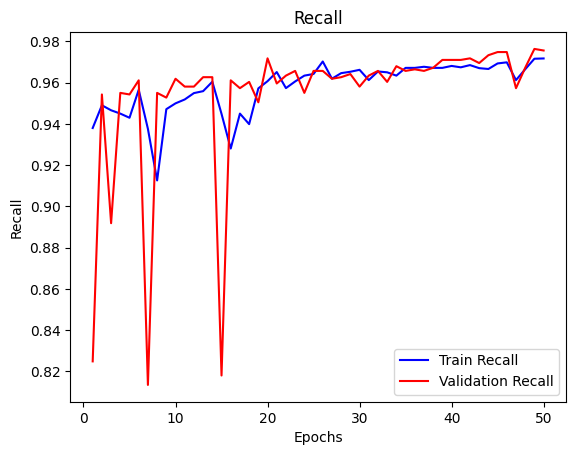

In [ ]:
# Получение значений метрики Recall на обучающем и валидационном наборах данных
train_recall = history.history['recall']
val_recall = history.history['val_recall']

# Получение значений эпох
epochs = range(1, len(train_recall) + 1)

# Визуализация метрики Recall
plt.plot(epochs, train_recall, 'b', label='Train Recall')
plt.plot(epochs, val_recall, 'r', label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

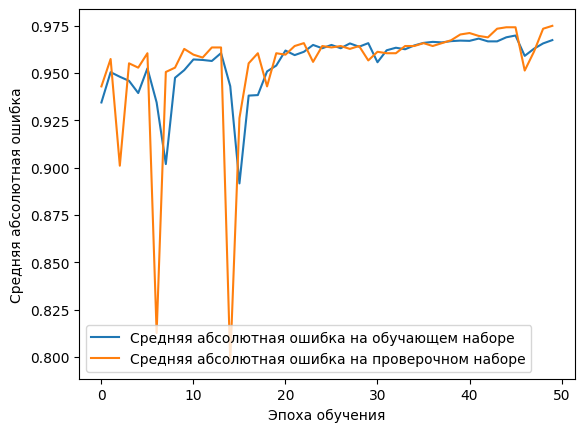

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
model=load_model("/content/drive/MyDrive/Colab Notebooks/Стажировка/architecture.hdf5")

In [ ]:
accuracy = model.evaluate((x_test_ohe,x_test_fact,\
x_test_text_MKB,x_test_text_diagn,\
x_test_text_cex,x_test_prof), y_test)
print("Accuracy:", accuracy)

49/49 [==============================] - 2s 31ms/step - loss: 0.3540 - recall: 0.9786 - accuracy: 0.9786
Accuracy: [0.35404476523399353, 0.9786407947540283, 0.9786407947540283]


In [ ]:
y_pred = model.predict((x_test_ohe,x_test_fact,x_test_text_MKB,x_test_text_diagn,\
                        x_test_text_cex,x_test_prof))

49/49 [==============================] - 1s 19ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

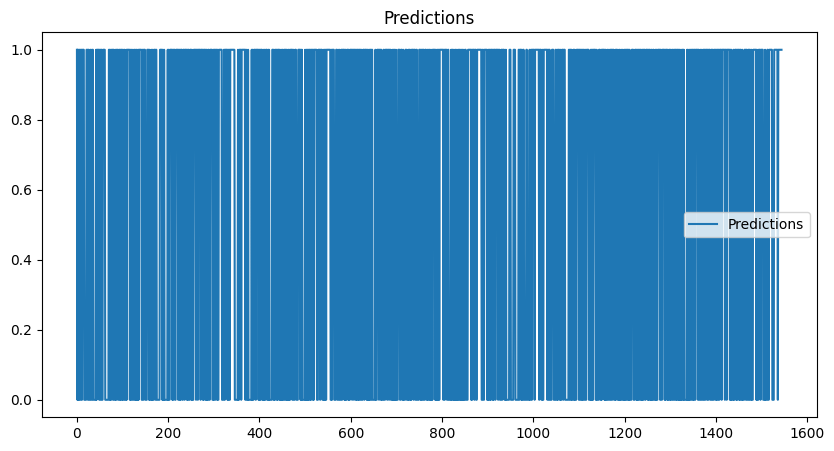

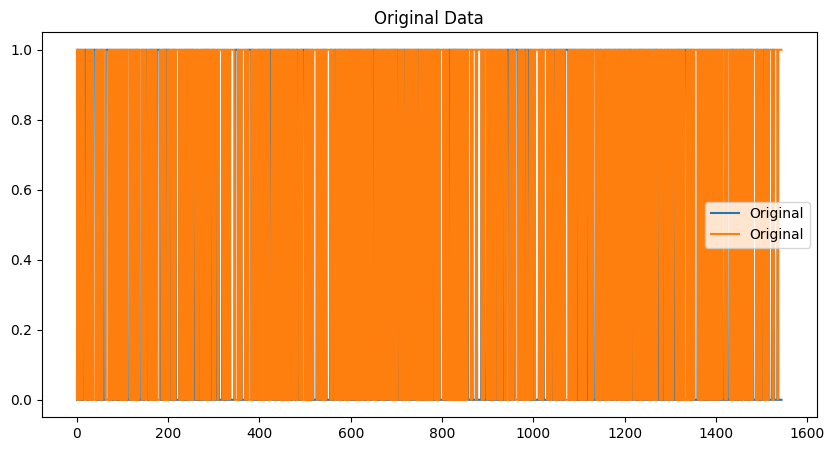

In [ ]:
import matplotlib.pyplot as plt

# Визуализация предсказаний
plt.figure(figsize=(10, 5))
plt.plot(y_pred_classes, label='Predictions')
plt.legend()
plt.title('Predictions')
plt.show()

# Визуализация оригинальных данных
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Original')
plt.legend()
plt.title('Original Data')
plt.show()

In [ ]:
evaluation = model.evaluate((x_test_ohe,x_test_fact,x_test_text_MKB,x_test_text_diagn,\
                             x_test_text_cex,x_test_prof), y_test)

49/49 [==============================] - 1s 24ms/step - loss: 0.3540 - recall: 0.9786 - accuracy: 0.9786


In [ ]:
accuracy = evaluation[1]

In [ ]:
print('Точность модели:', accuracy)

Точность модели: 0.9786407947540283


In [ ]:
print('Точность модели: %.2f%%' % (accuracy * 100))

Точность модели: 97.86%


In [ ]:
num_outputs = model.output_shape[-1]
print("Количество выходов модели:", num_outputs)

Количество выходов модели: 2


49/49 [==============================] - 1s 20ms/step


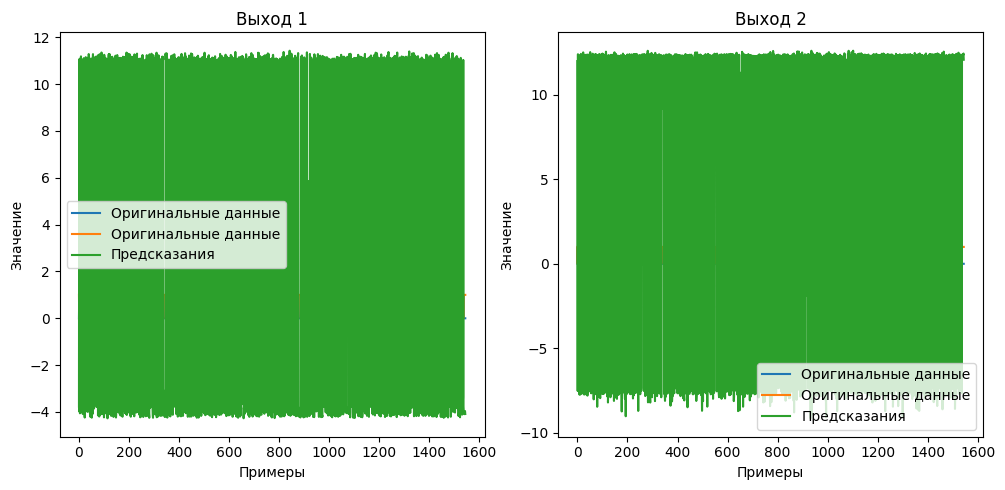

In [ ]:
# Получение предсказаний модели
predictions = model.predict((x_test_ohe,x_test_fact,x_test_text_MKB,x_test_text_diagn,\
                             x_test_text_cex,x_test_prof))

# Отображение графиков
plt.figure(figsize=(20, 5))

# График для первого выхода модели
plt.subplot(1, 4, 1)
plt.plot(range(len(y_test)), y_test, label='Оригинальные данные')
plt.plot(range(len(predictions)), predictions[:, 0], label='Предсказания')
plt.xlabel('Примеры')
plt.ylabel('Значение')
plt.title('Выход 1')
plt.legend()

# График для второго выхода модели
plt.subplot(1, 4, 2)
plt.plot(range(len(y_test)), y_test, label='Оригинальные данные')
plt.plot(range(len(predictions)), predictions[:, 1], label='Предсказания')
plt.xlabel('Примеры')
plt.ylabel('Значение')
plt.title('Выход 2')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# Округление предсказаний до ближайшего целого значения
rounded_predictions = np.argmax(predictions, axis=1)

# Создание матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1), rounded_predictions)

print(cm)

[[647   1]
 [ 32 865]]


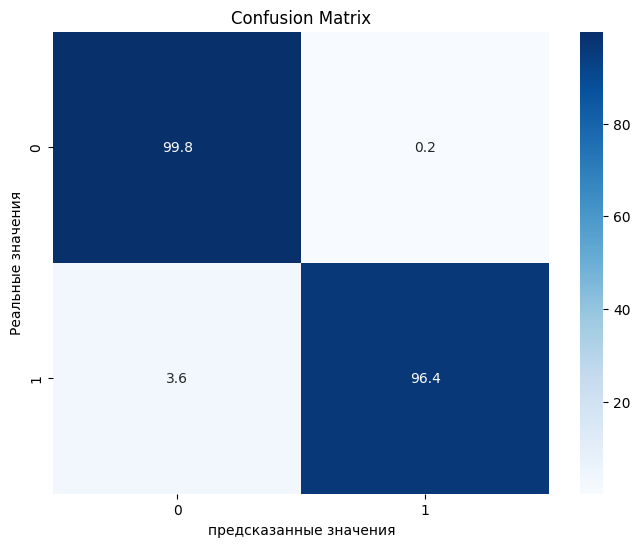

In [ ]:
# Получение предсказаний модели
rounded_predictions = np.argmax(predictions, axis=1)

# Создание матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1), rounded_predictions)

# Расчет процентов точности
cm_percent = cm / np.sum(cm, axis=1).reshape(-1, 1) * 100

# Создание тепловой карты (heatmap) для визуализации матрицы ошибок с процентами
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("предсказанные значения")
plt.ylabel("Реальные значения")
plt.show()

In [ ]:
dl_spavki = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/vred_fact(2).xlsx') #читаем предоставленную таблицу заказчика

In [ ]:
dl_spavki = dl_spavki.astype(str)

In [ ]:
data_dict_str = dl_spavki.set_index('код')['описание'].to_dict()

In [ ]:
data_dict_str

{'1.1': 'Азота неорганические соединения (в том числе азота оксиды (О), азота диоксид(О))',
 '1.2': 'Азотсодержащие органические соединения (в том числе амины, амиды, анилиды, гидразин и его производные, нитросоединения и прочие производные: NN-диметилацетамид(Р), NN-диметилформамид(Р), капролактам(АР) (гексагидро-2Н-азепин-2-он)',
 '1.3': 'Альдегиды алифатические (предельные и непредельные) и ароматические (формальдегид(АКРО), ацетальдегид, проп-2-ен-1-аль (акролеин), бензальдегид, бензол-1,2-дикарбальдегид (фталевый альдегид)',
 '1.4': 'Альдегиды и кетоны галогенопроизводные (хлорбензальдегид (4-хлорбензальдегид), фторацетон, хлорацетофенон)',
 '1.5': 'Алюминий и его соединения',
 '1.5.1': 'Алюмоплатиновые катализаторы(А)',
 '1.6': 'Бериллий и его соединения(АКР)',
 '1.7': 'Бор и его соединения',
 '1.7.1': 'Борная кислота, бор нитрид(Ф), бор трифторид(О), тетраБор карбид(Ф), тетраБор трисилицид(Ф)',
 '1.7.2': 'Бороводороды(О)',
 '1.8': 'Галогены',
 '1.8.1': 'Хлор(О)',
 '1.8.1.1': 'Хл

In [ ]:
#data_dict_str = {key: str(value) for key, value in data_dict.items()}

In [ ]:
print("Ключи в data_dict_str:", data_dict_str.keys())

Ключи в data_dict_str: dict_keys(['1.1', '1.2', '1.3', '1.4', '1.5', '1.5.1', '1.6', '1.7', '1.7.1', '1.7.2', '1.8', '1.8.1', '1.8.1.1', '1.8.1.2', '1.8.2', '1.8.2.1', '1.8.2.2', '1.8.3', '1.8.3.1', '1.8.3.2', '1.8.4', '1.8.4.1', '1.8.4.2', '1.9', '1.10', '1.11', '1.12', '1.13', '1.14', '1.14.1', '1.14.2', '1.15', '1.15.1', '1.16', '1.17', '1.18', '1.18.1', '1.18.2', '1.18.3', '1.19', '1.19.1', '1.19.2', '1.19.3', '1.20', '1.21', '1.22', '1.23', '1.24', '1.25', '1.26', '1.27', '1.27.1', '1.27.2', '1.28', '1.29', '1.29.1', '1.29.2', '1.29.3', '1.29.4', '1.29.5', '1.30', '1.30.1', '1.31', '1.32', '1.33', '1.34', '1.34.1', '1.34.2', '1.35', '1.36', '1.36.1', '1.36.2', '1.36.3', '1.37', '1.37.1', '1.37.1.1', '1.37.1.2', '1.37.2', '1.38', '1.39', '1.40', '1.40.1', '1.40.2', '1.41', '1.42', '1.43', '1.43.1', '1.43.2', '1.44', '1.45', '1.45.1', '1.45.2', '1.45.3', '1.46', '1.47', '1.47.1', '1.47.2', '1.47.3', '1.47.4', '1.47.5', '1.47.6', '1.47.7', '1.47.8', '1.47.9', '1.47.10', '1.47.11', '1

In [ ]:
# Выберите индекс конкретного примера, который хотите проверить
index = 1  # Замените на нужный индекс

# Получение предсказания для выбранного примера
prediction = model.predict((x_test_ohe[index:index+1], x_test_fact[index:index+1],\
                            x_test_text_MKB[index:index+1], x_test_text_diagn[index:index+1],\
                            x_test_text_cex[index:index+1], x_test_prof[index:index+1]))
predicted_class = np.argmax(prediction)

# Получение входных данных для выбранного примера
input_data1 = x_test_ohe[index]
input_data2 = x_test_fact[index]
input_data3 = x_test_text_MKB[index]
input_data4 = x_test_text_diagn[index]
input_data5 = x_test_text_cex[index]
input_data6 = x_test_prof[index]

class_labels = {
    1: "Следует обратить внимание на данного пациента. Решение об ограничении или допуске \
к исполнению трудовых обязательств принять коллегиально с узким специалистом соответствующего профиля(ей)",
    0: "годен"
}

predicted_label = class_labels[predicted_class]

# Получение МКБ из combined_df
text_pred = combined_df.loc[index, "Диагноз_текстом"]
mkb = combined_df.loc[index, "МКБ"]
vred_fact = combined_df.loc[index, colms5]
vred_fact_columns = vred_fact[vred_fact == "1"].index.tolist()
vred_fact_labels = [data_dict_str.get(key) for key in vred_fact_columns]

#print("вредные факторы:", vred_fact_labels)

# Вывод результатов
print("_________________________________________________________________")
print("Предсказание модели:", predicted_label)
print("МКБ (или список МКБ):", mkb)
print("Диагноз пациента (список диагнозов):", text_pred)
print("_________________________________________________________________")
print("")
print("Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)")
print("")
for col, label in zip(vred_fact_columns, vred_fact_labels):
    print(f"{col} - {label}")
print("_________________________________________________________________") 
print("Стоит обратить внимание, что данная система является рекомендательной, и предоставляемые предсказания не являются обязательными к исполнению")

1/1 [==============================] - 0s 31ms/step
_________________________________________________________________
Предсказание модели: годен
МКБ (или список МКБ): Z00
Диагноз пациента (список диагнозов): Общий медицинский осмотр
_________________________________________________________________

Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)

4.3.1 - Локальная вибрация
15 - Работы, выполняемые непосредственно на механическом оборудовании, имеющем открытые движущиеся (вращающиеся) элементы конструкции, в случае если конструкцией оборудования не предусмотрена защита (ограждение) этих элементов (в том числе токарные, фрезерные и другие станки, штамповочные прессы)
4.4 - Шум
_________________________________________________________________
Стоит обратить внимание, что данная система является рекомендательной, и предоставляемые предсказания не являются обязательными к исполнению


In [ ]:
# Выберите индекс конкретного примера, который хотите проверить
index = 0  # Замените на нужный индекс

# Получение предсказания для выбранного примера
prediction = model.predict((x_test_ohe[index:index+1], x_test_fact[index:index+1],\
                            x_test_text_MKB[index:index+1], x_test_text_diagn[index:index+1],\
                            x_test_text_cex[index:index+1], x_test_prof[index:index+1]))
predicted_class = np.argmax(prediction)

# Получение входных данных для выбранного примера
input_data1 = x_test_ohe[index]
input_data2 = x_test_fact[index]
input_data3 = x_test_text_MKB[index]
input_data4 = x_test_text_diagn[index]
input_data5 = x_test_text_cex[index]
input_data6 = x_test_prof[index]

class_labels = {
    1: "Следует обратить внимание на данного пациента. Решение об ограничении или допуске \
к исполнению трудовых обязательств принять коллегиально с узким специалистом соответствующего профиля(ей)",
    0: "годен"
}

predicted_label = class_labels[predicted_class]

# Получение МКБ из combined_df
text_pred = combined_df.loc[index, "Диагноз_текстом"]
mkb = combined_df.loc[index, "МКБ"]
vred_fact = combined_df.loc[index, colms5]
vred_fact_columns = vred_fact[vred_fact == "1"].index.tolist()
vred_fact_labels = [data_dict_str.get(key) for key in vred_fact_columns]

#print("вредные факторы:", vred_fact_labels)

# Вывод результатов
print("_________________________________________________________________")
print("Предсказание модели:", predicted_label)
print("МКБ (или список МКБ):", mkb)
print("Диагноз пациента (список диагнозов):", text_pred)
print("_________________________________________________________________")
print("")
print("Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)")
print("")
for col, label in zip(vred_fact_columns, vred_fact_labels):
    print(f"{col} - {label}")
print("_________________________________________________________________") 
print("Стоит обратить внимание, что данная система является рекомендательной, и предоставляемые предсказания не являются обязательными к исполнению")

1/1 [==============================] - 0s 109ms/step
_________________________________________________________________
Предсказание модели: Следует обратить внимание на данного пациента. Решение об ограничении или допуске к исполнению трудовых обязательств принять коллегиально с узким специалистом соответствующего профиля(ей)
МКБ (или список МКБ): H25, H52
Диагноз пациента (список диагнозов): 1.   Гиперметропия Описание: Гиперметропия ср ст ОД. Смешанный астигматизм ОС 2.   Начальная старческая катаракта
_________________________________________________________________

Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)

15 - Работы, выполняемые непосредственно на механическом оборудовании, имеющем открытые движущиеся (вращающиеся) элементы конструкции, в случае если конструкцией оборудования не предусмотрена защита (ограждение) этих элементов (в том числе токарные, фрезерные и другие станки, штамповочные прессы)
4.4 - Шу

Таким образом модель предсказывает годных с вероятностью 99,9 %, всех остальных на 96,4 %. При разъяснении нейронной сети нюансов каким образом происходит подразделение на еще и ограниченно годных возможно улучшение работы модели. Или же при достаточной базе данных от 5 000 примеров профпатологов по каждому из классов не годен и ограниченно годен появится возможность обучить модель без искусственного изменения за счет данных из приказа

- Необходимо получить более объемный дата-сет с данными с большим кол-вом примеров для классов ограниченно годен и временно негоден. Иначе нейронную сеть не обучить должным образом. Без конкретных примеров она будет продолжать делать ошибки на классе "ограничено годен", что с медицинской точки зрения неприемлемо. В данном случае создана нейронная сеть отсеивающая явно годных и тех на кого следует обратить внимание профпатолога. Такой подход считаю обоснованным т.к. не в моей компетенции видоизменять данные приказа н29 и отбирать оттуда примеры на свое усмотрение для повышения точности по классу "ограничено годен".

- При поддержке профпатолога необходимо подробнее разобрать приказ н29 для получения четкого понимания как распределять пациентов на ограниченно годных и негодных для дальнейшей искусственной аугментации данных четкими критериями отбора